In [8]:
# Import
from FEnicS_base import *
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
from Parametrs import *
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
import inspect
from tqdm import tqdm


class ArrayFunc:

    def __init__(self, func: fem.Function, name=None):
        self.cord = np.array([
            func.function_space.tabulate_dof_coordinates()[:, 0],
            func.x.array,
        ])
        self._sort()
        self.cord = np.array([[a, b]for a, b in enumerate(self.cord[1])]).transpose() #yapf: disable
        self.len = len(self.cord[0])
        self.name = name

    def _sort(self):
        self.cord = self.cord[:, np.argsort(self.cord[0])]

    def translate(self, point_0):
        x_new = (self.cord[0] - point_0)
        self.cord[0] = x_new - self.len * (x_new // (self.len))
        self._sort()

    def mirror(self, point_0):
        self.translate(point_0)
        self.cord[0] = -self.cord[0]
        self.cord[0] += self.len
        self._sort()


def clear_savedir(path_save):
    """Clear directory in VTK folder"""

    try:
        shutil.rmtree(path_save)
    except:
        pass


def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def repr_str(func, rules: list = {}) -> str:
    # TODO: to module
    # FIXME: (( to (\n(
    rep = str(func)
    rep = re.sub(r'\{ A \| A_\{i_(\d|\{\d+\})\} \=', '', rep)
    rep = re.sub(r'\[i_(\d|{\d+})]', '', rep)
    rep = re.sub(r'dx.+\)', 'dx', rep)
    rep = re.sub(r'ds.+\)', 'ds', rep)
    for key, raw in rules.items():
        rep = rep.replace(str(raw),key)

    base = {
        'v_0[0]': 'v',
        'v_0[1]': 'u',
        '-1 * ': '-',
        '+ -': '-',
        'f[0]': 'N',
        'f[1]': 'P',
        '{': '{\n',
        '} *': '\n} *',
    }
    for key, raw in base.items():
        rep = rep.replace(key, raw)

    beauty = {
        '(grad(P))': 'grad(P)',
        '(grad(N))': 'grad(N)',
        '(grad(u))': 'grad(u)',
        '(grad(v))': 'grad(v)',
        '})': ')',
        '+ (': '\n   +(',
    }
    for key, raw in beauty.items():
        rep = rep.replace(key, raw)
    return rep


In [28]:
# Set up parametrs
_consts = Param_const(
    gen_rate=0.01,
    a_rate=1,
    b_rate=0.1,
    e_rate=0.5,
    P_step=0.13,
)
_sol = Param_solve_confs(
    solve_opts={
        'convergence': 'incremental', 'tolerance': 1E-6
    }
)

DATA = Param_DATA(
     # solve_confs=sol,
     save=Param_save(save_name='input', desc='input'),
     # bcs=Param_bcs(
     #     bcs_kind='like_inside',
     #     N_pars={'N_ext': 0.2, 'P_ext': 0.001},
     #     P_pars={'N_ext': 0.2, 'P_ext': 0.001},
     # ),
    time=Param_time(dt=0.001, ),
    consts=_consts,
    light=Param_light(kind='sigmoid', left=0.1, right=0.3, slope=50),
    mesh=Param_mesh(intervals=100, degree=2),
)

In [29]:
# Task
# yapf: disable
N, P = 'N', 'P'
DOMAIN = mesh.create_interval(
    nx=DATA.mesh.intervals,
    comm=MPI.COMM_WORLD,
    points=[DATA.mesh.left, DATA.mesh.right],
)
element = {
    N:ufl.FiniteElement(
        family='CG',
        cell=DOMAIN.ufl_cell(),
        degree=DATA.mesh.degree),
    P:ufl.FiniteElement(
        family='CG',
        cell=DOMAIN.ufl_cell(),
        degree=DATA.mesh.degree)
    }
SPACE = FunctionSpace(
    mesh=DOMAIN,
    element=ufl.MixedElement(element[N], element[P]),
)
SUBSPACE = {
    N: SPACE.sub(0).collapse()[0],
    P: SPACE.sub(1).collapse()[0],
}
X = SpatialCoordinate(SPACE)[0]

FUNC, FUNC0 = Function(SPACE), Function(SPACE)
SUB_FUNC = {
    N: FUNC.sub(0),
    P: FUNC.sub(1),
}
INDIC = {
    N: split(FUNC)[0],
    P: split(FUNC)[1],
}
INDIC_0 = {
    N: split(FUNC0)[0],
    P: split(FUNC0)[1],
}

TIME = Constant(SUBSPACE[N], 0)

class Light_collection:

    def __init__(self, x: SpatialCoordinate, x0, slope):
        self.x = x
        self.x0 = x0
        self.slope = slope

    def create(self, kind: str):
        assert kind in Light_collection.get_kinds(False), 'Not implemented method'
        return getattr(self, kind)()

    @staticmethod
    def _kind_ready(func=None, get=False, l=set()):
        if not get:
            l.add(func.__name__)
            return func
        else:
            return l

    @classmethod
    def get_kinds(cls, view=True):
        kinds = cls._kind_ready(get=True)
        if not view:
            return kinds
        else:
            print('\n'.join(kinds))

    def _singP(self):
        return (1 + ufl.sign(self.slope)) / 2

    def _singM(self):
        return (1 - ufl.sign(self.slope)) / 2

    @_kind_ready
    def step(self):
        return conditional(self.x0 <= self.x, self._singP(), self._singM())

    @_kind_ready
    def sigmoid(self):
        a = self.slope * 5
        return 1 / (1 + exp(-a * (self.x - self.x0)))

    @_kind_ready
    def trapsharp(self):
        a = self.slope
        res = conditional(
            ufl.And(
                self.x0 - 1 / (abs(2 * a)) <= self.x,
                self.x < self.x0 + 1 / (abs(2 * a))
            ),
            a * (self.x - self.x0) + 0.5,
            0,
        )
        res += conditional(
            self.x0 + 1 / (2*a) <= self.x,
            self._singP(),
            self._singM(),
        )
        return res

    @_kind_ready
    def parab(self):
        a = self.slope * 5
        res = conditional(
            ufl.And(
                self.x0 - 1 / sqrt(abs(2 * a)) <= self.x,
                self.x < self.x0,
            ),
            a * (self.x - self.x0 + 1 / sqrt(abs(2 * a)))**2 + self._singM(),
            0
        )
        res += conditional(
            ufl.And(
                self.x0 <= self.x,
                self.x < self.x0 + 1 / sqrt(abs(2 * a)),
            ),
            -a * (self.x - self.x0 - 1 / sqrt(abs(2 * a)))**2 + self._singP(),
            0
        )
        res += conditional(
            self.x0 + 1 / (ufl.sign(a) * sqrt(abs(2 * a))) <= self.x,
            self._singP(),
            self._singM()
        )
        return res
def create_light(x: SpatialCoordinate, data: Param_light):
    res = Light_collection(
        x=x,
        x0=data.left,
        slope=data.slope,
    ).create(kind=data.kind)
    res *= Light_collection(
        x=x,
        x0=data.right,
        slope=-data.slope,
    ).create(kind=data.kind)
    return res
LIHGT = create_light(x=X, data=DATA.light)

def create_consts(indic, data):
    p = indic[P]
    n = indic[N]

    gen_rate = data.gen_rate
    step_P = data.P_step
    a_nm = gen_rate * data.a_rate
    b_pm = gen_rate * data.b_rate * exp(-p / step_P)
    e_np = gen_rate * data.e_rate * exp(-p / step_P)

    gamma = data.gamma
    m = 1 - p - n
    under_ln = m / (1-n)
    power = (gamma-1) / gamma
    reaction = gamma * m * (-ln(under_ln))**power

    return {
        'A_NM': a_nm,
        'B_PM': b_pm,
        'E_NP': e_np,
        'REACTION': reaction,
    }
CONST = create_consts(indic=INDIC, data=DATA.consts)

class Surface_collection:

    def __init__(self, kind, indic, consts, data_mesh):
        assert kind in self._kind_ready(get=True).keys(), 'Not implemented method'
        self.indic = indic
        self.consts = consts
        self.data_mesh = data_mesh
        self.kind = kind

    def create(self, **parametrs):
        return getattr(self, self.kind)(**parametrs)

    @staticmethod
    def _kind_ready(func=None, get=False, l={}):
        if not get:
            args = set(inspect.getfullargspec(func).args)
            args.remove('self')
            l.update({func.__name__: ','.join(args)})
            return func
        else:
            return l

    @classmethod
    def get_kinds(cls, view=True):
        kinds = cls._kind_ready(get=True)
        if not view:
            return kinds
        else:
            [
                print(kind, ':', args.replace(',', ', ')) for kind,
                args in kinds.items()
            ]

    @_kind_ready
    def close(self, f: fem.Function):
        return 0

    @_kind_ready
    def robin(self, f: fem.Function, const, ext):
        return -const * (ext-f)

    @_kind_ready
    def fixed_flux(self, f: fem.Function, value):
        return -value

    @_kind_ready
    def like_inside(self, f, N_ext, P_ext):
        h = (
            self.data_mesh.right - self.data_mesh.left
        ) / self.data_mesh.intervals
        n, p = self.indic.N, self.indic.P
        if f == n:
            flux_N = 0
            flux_N += -self.consts['A_NM'] * (N_ext-n)
            flux_N += +self.consts['A_NM'] * p * (N_ext-n)
            flux_N += -self.consts['E_NP'] * p * (N_ext-n)
            flux_N += -self.consts['A_NM'] * n * (P_ext-p)
            flux_N += +self.consts['E_NP'] * n * (P_ext-p)
            return flux_N / h
        elif f == p:
            flux_P = 0
            flux_P += -self.consts['B_PM'] * (P_ext-p)
            flux_P += +self.consts['B_PM'] * n * (P_ext-p)
            flux_P += -self.consts['E_NP'] * n * (P_ext-p)
            flux_P += -self.consts['B_PM'] * p * (N_ext-n)
            flux_P += +self.consts['E_NP'] * p * (N_ext-n)
            return flux_P / h
sur_factory = Surface_collection(
    kind=DATA.bcs.kind, indic=INDIC, consts=CONST, data_mesh=DATA.mesh
)
SURFACE = {
    N: sur_factory.create(f=INDIC[N], **DATA.bcs.N),
    P: sur_factory.create(f=INDIC[P], **DATA.bcs.P),
}

def create_bcs():
    return []
BCS = create_bcs()


def create_equation():

    def create_facets():
        set_connectivity(DOMAIN)
        ds = Measure("ds", domain=DOMAIN)
        return ds

    def inside_flux(
        a_NM=CONST['A_NM'],
        b_PM=CONST['B_PM'],
        e_NP=CONST['E_NP'],
    ):
        flux_N = 0
        flux_N += -a_NM * grad(n)
        flux_N += +a_NM * p * grad(n)
        flux_N += -e_NP * p * grad(n)
        flux_N += -a_NM * n * grad(p)
        flux_N += +e_NP * n * grad(p)

        flux_P = 0
        flux_P += -b_PM * grad(p)
        flux_P += +b_PM * n * grad(p)
        flux_P += -e_NP * n * grad(p)
        flux_P += -b_PM * p * grad(n)
        flux_P += +e_NP * p * grad(n)
        return flux_N, flux_P

    dt = DATA.time.dt
    ds = create_facets()

    u, v = TestFunctions(SPACE)
    n, p = INDIC[N], INDIC[P]
    n0, p0 = INDIC_0[N], INDIC_0[P]
    qN, qP = inside_flux()

    equationN = (1/dt) * (n-n0) * u * dx
    equationN += -(qN|inner|grad(u)) * dx
    equationN += u * SURFACE[N] * ds

    equationP = (1/dt) * (p-p0) * v * dx
    equationP += -(qP|dot|grad(v)) * dx
    equationP += -LIHGT * CONST['REACTION'] * v * dx
    equationP += v * SURFACE[P] * ds

    return {N: equationN, P: equationP}
EQUATION = create_equation()
# FIXME: clear reset KSP solver
PROBLEM = []

def set_initial(
    data: Param_initial = DATA.initial,
    confs=DATA.solve_confs,
):
    # TODO: reset bcs
    SUB_FUNC[N].interpolate(Function(SUBSPACE[N], data.N0))
    SUB_FUNC[P].interpolate(Function(SUBSPACE[P], data.P0))

    FUNC.x.scatter_forward()
    FUNC0.interpolate(FUNC)

    TIME.value = 0
    global PROBLEM
    PROBLEM = NonlinearProblem(
        F=sum(EQUATION.values()),
        bcs=BCS,
        u=FUNC,
        solve_options=confs.solve_opts,
        petsc_options=confs.petsc_opts,
        form_compiler_params=confs.form_opts,
        jit_params=confs.jit_opts,
    )
set_initial()


def dump(save=False, save_data=DATA.dump):
    consts = CONST.copy()
    save_data.consts = {key: repr_str(value) for key, value in consts.items()}
    consts.update({'LIGHT': LIHGT})
    save_data.equations = {
        key: repr_str(value, consts)
        for key, value in EQUATION.items()
    }

    if not save:
        print(DATA.dump.EQUATION_N)
        print('*' * 80)
        print(DATA.dump.EQUATION_P)
    else:
        with open(
            DATA.save.dir_save + DATA.save.save_name + DATA.save.file_name +
            '_anotaton.txt',
            'w',
        ) as annotation:
            annotation.write(jp.encode(DATA, numeric_keys=True, indent=4))
    pass


def solve(n_steps=DATA.time.n_steps, reset=True, save=False):

    def _set_next():
        # TODO: interpolate bcs
        FUNC0.interpolate(FUNC)
        TIME.value += DATA.time.dt

    def _solve_default(steps):
        for step in steps:
            _set_next()
            steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
            PROBLEM.solve()

    def _solve_with_save(steps, data_save: Param_save = DATA.save):

        def _save_functions(file, time):
            file.write_function(SUB_FUNC[N], time)
            file.write_function(SUB_FUNC[P], time)
            # flux_N = Function(SUBSPACE[N], SURFACE[N])
            # flux_N.name = 'flux_N'
            # file.write_function(flux_N, time)

            # flux_P = Function(SUBSPACE.P, SURFACE.P)
            # flux_P.name = 'flux_P'
            # file.write_function(flux_P, time)

        clear_savedir(data_save.dir_save + data_save.save_name)
        save_path = data_save.dir_save + data_save.save_name + data_save.file_name
        check_every = int(DATA.time.n_steps / DATA.time.n_shecks)

        SUB_FUNC[N].name = 'neutral'
        SUB_FUNC[P].name = 'polimer'
        light = Function(SUBSPACE[N], LIHGT)
        light.name = 'Light'
        with io.XDMFFile(DOMAIN.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(DOMAIN)
            for step in steps:
                if step % check_every == 0:
                    steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
                    _save_functions(file, TIME.value)
                _set_next()
                PROBLEM.solve()
            _save_functions(file, TIME.value)
        dump(True)

    if reset: set_initial()
    steps_line = tqdm(
        desc=f'Solving PDE. Time:{TIME.value:.3f}',
        iterable=np.arange(0, n_steps, dtype=int),
    )
    if save: _solve_with_save(steps_line, data_save=DATA.save)
    else: _solve_default(steps_line)


def draw(show_fluxes=False, flux_scale=100, show_points=False):
    col_light = Function(SUBSPACE[N], LIHGT, 'Light')
    col_funcs = {}
    col_fluxes = {}

    for key in SUB_FUNC.keys():
        col_funcs.update({key: Function(SUBSPACE[key], SUB_FUNC[key], key)})
        col_fluxes.update({key:Function(SUBSPACE[key], flux_scale * SURFACE[key], 'flux_' + key)}) #yapf: disable
    col_M = Function(SUBSPACE[N], 1 - col_funcs[N] - col_funcs[P], 'M')

    collection = [col_M, col_light, *col_funcs.values()]
    if show_fluxes: collection.append(*col_fluxes.values())
    func_plot1D(funcs=collection, show_points=show_points)


def check_symmetry(
    func: fem.Function,
    add_point=0,
    data=DATA,
):
    from matplotlib.ticker import FormatStrFormatter

    def find_middle(add_point):
        middle_x = (data.light.left + data.light.right) / 2
        middle_point = int((data.mesh.left + middle_x) /
                           (data.mesh.right - data.mesh.left) * base.len)
        middle_point += add_point
        return middle_point

    def plot(func: ArrayFunc):
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(20, 10)
        ax.grid(True, which='Both')
        ax.set_xlim((min(func.cord[0]), max(func.cord[0])))
        ax.set_ylim((min(func.cord[1]), max(func.cord[1])))
        ax.yaxis.set_major_formatter(FormatStrFormatter(('%.3f')))
        plt.plot([middle, middle], (min(func.cord[1]), max(func.cord[1])),
                 c='red')

        ax.plot(func.cord[0], func.cord[1], label=func.name, color='black')
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] > func.cord[1] * 0,
            alpha=0.5,
            facecolor='green',
            label=func.name,
        )
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] < func.cord[1] * 0,
            alpha=0.5,
            facecolor='red',
            label=func.name,
        )

    print('Rule: Right - left')
    base = ArrayFunc(func, 'base')
    dif = ArrayFunc(func, 'dif')
    middle = find_middle(add_point)

    dif.mirror(middle)
    dif.translate(-middle)
    dif.cord[1] = (dif.cord[1] - base.cord[1]) / base.cord[1]
    dif.cord[1, dif.cord[0] >= middle] = 0
    plot(dif)
    plot(base)


Solving PDE. Time:0.90: 100%|██████████| 1000/1000 [00:05<00:00, 183.02it/s]


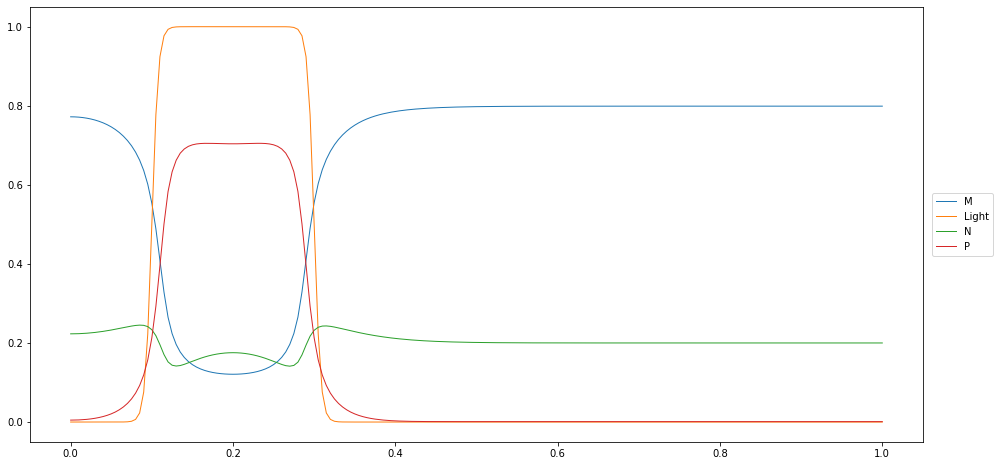

In [30]:
solve(
     save=True,
     # n_steps=2000,
    reset=True,
)
draw()

Rule: Right - left


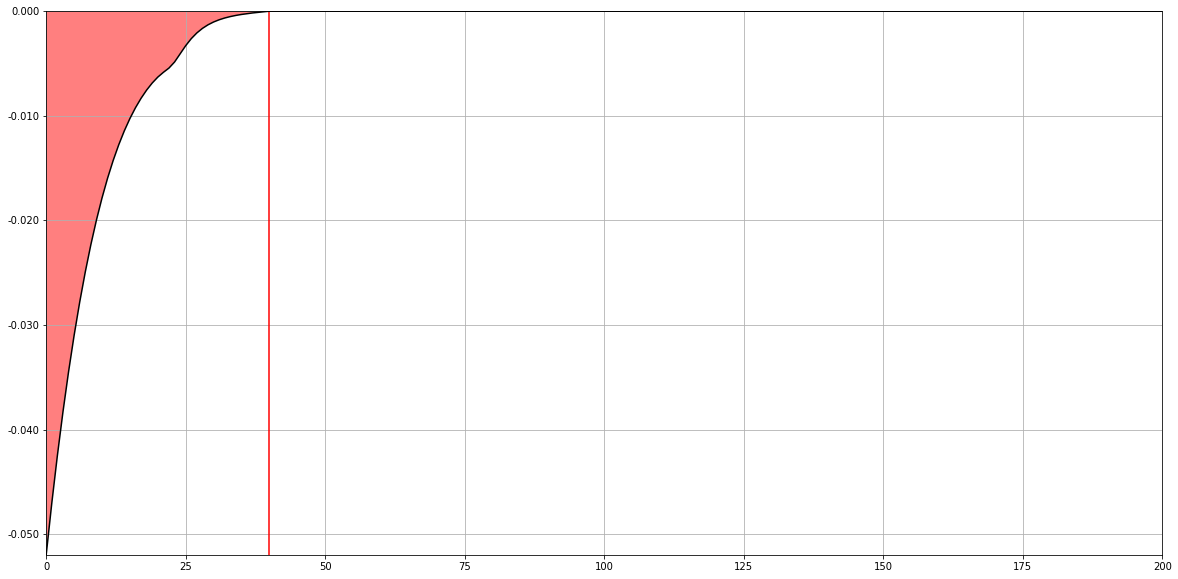

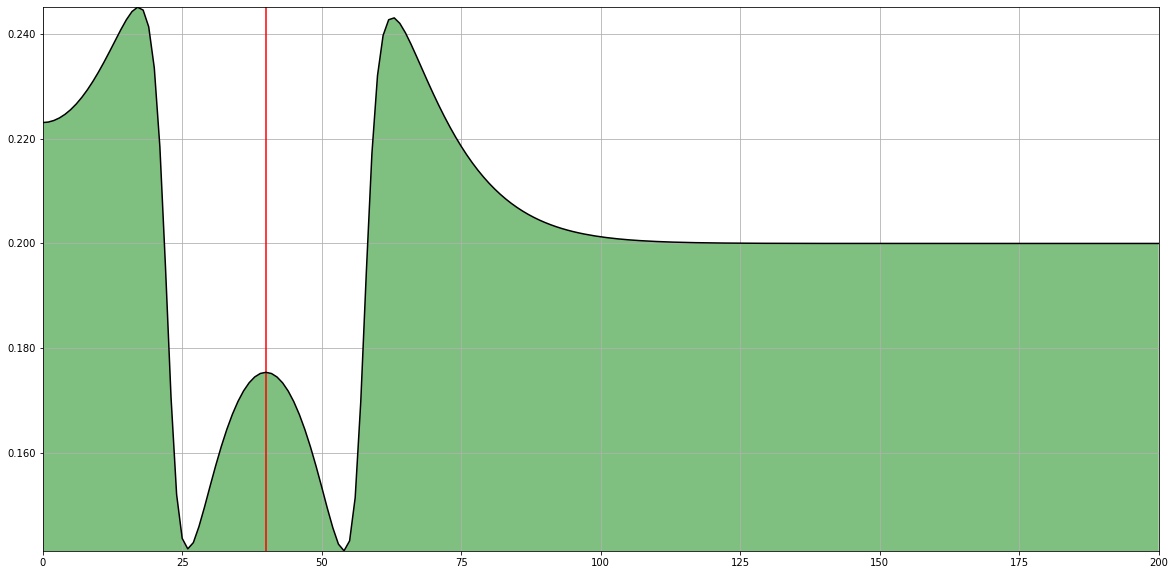

In [31]:
check_symmetry(add_point=0, func=Function(SUBSPACE[N], SUB_FUNC[N], 'neutral'))